# SQL Analysis Development Notebook

This notebook is used for testing code concepts for the SQL Analysis module.

## Table of Contents

<ol>
    <li><a href='#start'>Modifying Class Dictionary</a></li>
    <li><a href='#create'>Create Tables</a></li>
    <li><a href='#test'>Test Functionality</a></li>
    <li><a href='#summary'>Summarize Function</a></li>
</ol>

<a id='start'></a>
## Modifying Class Dictionary

In [1]:
class DictTest:
    def __init__(self):
        self.my_dict = {}
        self.label = 'count'
    
    def run_test(self, value):
        if value > 10:
            self.my_dict[self.label] = value

In [2]:
tester = DictTest()

my_list = [1, 15, 6, 8, 20, 13]
my_labels = ['abc', 'xyz', 'def', 'lmn', 'ijk', 'str']

for value, label in zip(my_list, my_labels):
    tester.label = label
    tester.run_test(value)

In [3]:
tester.my_dict

{'xyz': 15, 'ijk': 20, 'str': 13}

<a id='create'></a>
## Create Tables

In [37]:
from importlib import reload
import numpy as np
import pandas as pd
from sqlalchemy import types

import sql_analysis as san
from sql_config_example import ENGINE_DVD

In [29]:
create_str = "\
SELECT \
    CAST(EXTRACT(YEAR FROM r.rental_date) AS TEXT) || '-' ||  CAST(EXTRACT(MONTH FROM r.rental_date) AS TEXT) AS ss_dt \
    , r.rental_id \
    , r.rental_date \
    , f.title \
    , f.length \
    , f.rating \
FROM rental r \
    JOIN inventory i \
        ON i.inventory_id = r.inventory_id \
    JOIN film f \
        ON f.film_id = i.film_id"

df = san.sql_query(create_str, 'dvd')

In [30]:
df.head()

,ss_dt,rental_id,rental_date,title,length,rating
0,2005-5,2,2005-05-24 22:54:33,Freaky Pocus,126,R
1,2005-5,3,2005-05-24 23:03:39,Graduate Lord,156,G
2,2005-5,4,2005-05-24 23:04:41,Love Suicides,181,R
3,2005-5,5,2005-05-24 23:05:21,Idols Snatchers,84,NC-17
4,2005-5,6,2005-05-24 23:08:07,Mystic Truman,92,NC-17


In [19]:
df.rental_date.describe()

count                   16044
unique                  15815
top       2006-02-14 15:16:03
freq                      182
first     2005-05-24 22:53:30
last      2006-02-14 15:16:03
Name: rental_date, dtype: object

Generate random timestamps via this [StackOverflow answer](https://stackoverflow.com/questions/553303/generate-a-random-date-between-two-other-dates).

In [20]:
from random import randrange
from datetime import timedelta

def random_date(start, end):
    """
    This function will return a random datetime between two datetime 
    objects.
    """
    delta = end - start
    int_delta = (delta.days * 24 * 60 * 60) + delta.seconds
    random_second = randrange(int_delta)
    return start + timedelta(seconds=random_second)

In [23]:
random_dates = []
for _ in np.arange(df.shape[0]):
    random_dates.append(random_date(df.rental_date.min(),
                                    df.rental_date.max()))

Create alternate view for comparison testing.

In [31]:
alt_rental_view = df.copy()
alt_rental_view['rental_date'] = random_dates
alt_rental_view['ss_date'] = alt_rental_view['rental_date'].dt.year.astype(str) \
                             + '-' + alt_rental_view['rental_date'].dt.month.astype(str)
alt_rental_view.drop('ss_dt', axis=1, inplace=True)

In [32]:
alt_rental_view.head()

,rental_id,rental_date,title,length,rating,ss_date
0,2,2005-12-02 22:58:47,Freaky Pocus,126,R,2005-12
1,3,2005-11-04 04:06:39,Graduate Lord,156,G,2005-11
2,4,2005-10-08 19:37:49,Love Suicides,181,R,2005-10
3,5,2005-09-03 13:17:21,Idols Snatchers,84,NC-17,2005-9
4,6,2005-10-31 02:40:27,Mystic Truman,92,NC-17,2005-10


Create tables in database

In [39]:
alt_rental_view.to_sql('alt_rental_view', 
                       ENGINE_DVD, 
                       if_exists='replace', 
                       index=False,
                       dtype={"rental_id": types.Integer(),
                              "rental_date": types.Date(),
                              "title": types.VARCHAR(length=255),
                              "length": types.Integer(),
                              "rating": types.VARCHAR(length=6),
                              "ss_date": types.VARCHAR(length=8)})

In [41]:
df.to_sql('rental_view',
          ENGINE_DVD,
          if_exists='replace',
          dtype={"rental_id": types.Integer(),
                 "ss_dt": types.VARCHAR(length=8),
                 "rental_date": types.Date(),
                 "title": types.VARCHAR(length=255),
                 "length": types.Integer(),
                 "rating": types.VARCHAR(length=6)})

<a id='test'></a>
## Test Functionality

In [45]:
rental_view = san.sql_query('SELECT * FROM rental_view', 'dvd')
rental_view.head()

,index,ss_dt,rental_id,rental_date,title,length,rating
0,0,2005-5,2,2005-05-24,Freaky Pocus,126,R
1,1,2005-5,3,2005-05-24,Graduate Lord,156,G
2,2,2005-5,4,2005-05-24,Love Suicides,181,R
3,3,2005-5,5,2005-05-24,Idols Snatchers,84,NC-17
4,4,2005-5,6,2005-05-24,Mystic Truman,92,NC-17


In [46]:
alt_rental_view = san.sql_query('SELECT * FROM alt_rental_view', 'dvd')
alt_rental_view.head()

,rental_id,rental_date,title,length,rating,ss_date
0,2,2005-12-02,Freaky Pocus,126,R,2005-12
1,3,2005-11-04,Graduate Lord,156,G,2005-11
2,4,2005-10-08,Love Suicides,181,R,2005-10
3,5,2005-09-03,Idols Snatchers,84,NC-17,2005-9
4,6,2005-10-31,Mystic Truman,92,NC-17,2005-10


In [43]:
# Specify table fields - "target" table is first
comparison_fields = ('rental_id','rental_id')
groupby_fields = ('ss_dt', 'ss_date')
table_names = ('rental_view', 'alt_rental_view')
table_alias = ('rvw', 'alt')

# Create data gatherer
gatherer = san.SQLGatherData(comparison_fields,
                             groupby_fields,
                             table_names,
                             table_alias,
                             db_server='dvd',
                             test_type='count')

# Get data for 'count' test
count_df = gatherer.gather_data()
count_df

Commencing rental_id query...
Query for rental_id complete.



,ss_dt,rvw_count,alt_count
0,2005-5,1156,417
1,2005-6,2311,1856
2,2005-7,6709,1795
3,2005-8,5686,1835
4,2006-2,182,857


In [44]:
# Create basic tester
tester = san.SQLUnitTest(count_df,
                         comparison_names=table_alias)

tester.run_test()
tester._results

Commencing test for count...
PRIORITY REVIEW on alt_count: 67.72775237425255
Test for count complete.



,date,ss_dt,rvw_count,alt_count,rvw_minus_alt,perc_diff_alt
0,03-Aug-19,2005-5,1156,417,739,63.927336
1,03-Aug-19,2005-6,2311,1856,455,19.688447
2,03-Aug-19,2005-7,6709,1795,4914,73.244895
3,03-Aug-19,2005-8,5686,1835,3851,67.727752
4,03-Aug-19,2006-2,182,857,-675,-370.879121


<a id='summary'></a>
## Summarize Function

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt

In [54]:
reload(san)

<module 'sql_analysis' from 'C:\\Users\\rebecca\\Git-Hub-Repos\\sql_analysis\\sql_analysis.py'>

In [55]:
high_distinct = [('rental_date', 'rental_date'),
                 ('title', 'title')]

tester = san.SQLUnitTest(count_df,
                         comparison_names=table_alias)
tester.summary_field = 'ss_dt'

for comparison_fields in high_distinct:
    gatherer.comparison_fields = comparison_fields
    df = gatherer.gather_data()
    
    tester.data = df
    tester.test_field = comparison_fields[0]
    
    tester.run_test()

Commencing rental_date query...
Query for rental_date complete.

Commencing test for rental_date...
PRIORITY REVIEW on alt_rental_date: 67.72775237425255
Test for rental_date complete.

Commencing title query...
Query for title complete.

Commencing test for title...
PRIORITY REVIEW on alt_title: 67.72775237425255
Test for title complete.



In [60]:
tester._summary

,ss_dt,rental_date_alt,title_alt
0,2005-5,63.927336,63.927336
1,2005-6,19.688447,19.688447
2,2005-7,73.244895,73.244895
3,2005-8,67.727752,67.727752
4,2006-2,-370.879121,-370.879121


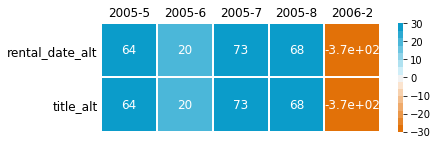

In [123]:
summary_data = tester._summary.copy()
summary_data.index = summary_data.ss_dt
summary_data.drop('ss_dt', axis=1, inplace=True)
plt.figure(figsize=(summary_data.shape[0] * 1.25, summary_data.shape[1]))
ax = sns.heatmap(summary_data.transpose(), 
                 vmin=-30,
                 vmax=30,
                 cmap=sns.diverging_palette(30, 230, s=99, l=60, n=15),
                 center=0,
                 annot=True,
                 annot_kws={'fontsize':12},
                 linewidths=1)
ax.xaxis.tick_top()
ax.tick_params(axis='both', which='both', length=0, rotation=0, labelsize=12)
plt.xlabel('');